<a href="https://colab.research.google.com/github/YUMVOLKOVA/Topic-Modeling/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: Topic Modeling
#### Волкова Юлия, МОиАД, 2 курс

### Задание
Постройте тематическую модель обращений в YouTrack от внешних пользователей в течение последних пяти релизов PyCharm. Визуализируйте её так, чтобы по визуализации можно было бы (хотя бы попытаться) ответить на два следующих вопроса:
1. Каковы основные причины для обращений в релизе 2020.2?
2. Какие новые проблемы добавились в релизе 2020.3 и какие ушли, по сравнению с релизом 2020.2?


### Данные

Считываем данные 

In [1]:
import tqdm.notebook as tq

In [7]:
# from google.colab import files
# uploaded = files.upload()
# import pandas as pd
# import io
# df = pd.read_json(io.StringIO(uploaded['pycharm_issues.json'].decode('utf-8')), lines=True)

In [ ]:
# import pandas as pd
# df = pd.read_json('pycharm_issues.json', lines=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_json('/content/drive/MyDrive/Prod/pycharm_issues.json', lines=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Посмотрим на наши данные 

In [3]:
df

,idReadable,created,summary,description,Affected versions
0,PY-22135,1483471995465,"""Parameter foo unfilled"": false positives for ...","I'm getting false ""Incorrect call argument"" in...",[2016.3]
1,PY-22143,1483528763930,Python Extract Superclass: Incorrect Order of ...,"When extracting superclasses, if extractions i...",[2016.3]
2,PY-22145,1483545972098,Inspection does not report 'Unresolved Referen...,If a variable is deleted using the `del` state...,[2016.2]
3,PY-22149,1483572086024,ipython notebook clear_output() not working,"Below code should print only once ""Hellow Worl...",[]
4,PY-22128,1483387969625,False negative: no error for round brackets in...,I believe it's rather a common typo to use rou...,[2017.1]
...,...,...,...,...,...
22009,PY-51597,1636879129851,Intellij don't recognize python3 installed by ...,"\n\nIU-212.5457.46, JRE 11.0.12+7-b1504.40x64 ...",[]
22010,PY-51594,1636908525899,url tag in django template that uses filters o...,When using the {% url %} tag in a Django templ...,[]
22011,PY-51588,1636866008572,Variable incorrectly marked as used,"Hi, in this example, tha variable 'idocking' i...",[]
22012,PY-51595,1636912616563,Warn on invalid iterable unpack,```python\nimport time\n\ndef foo() -> float:\...,[2021.2]


"...в течение последних пяти релизов ..." $->$ фильтруем датасет по пяти последним значениям Affected versions

In [4]:
import itertools
last_five = sorted(list(set(list(itertools.chain(*df['Affected versions'])))))[-5:]

In [5]:
last_five = [[i] for i in last_five]
last_five

[['2020.2'], ['2020.3'], ['2021.1'], ['2021.2'], ['2021.3']]

In [6]:
for i in tq.tqdm(range(len(df['Affected versions']))):  
  if df.loc[(i, 'Affected versions')] not in last_five:
    df = df.drop(i)

  0%|          | 0/22014 [00:00<?, ?it/s]

In [7]:
df.reset_index(inplace=True, drop=True)
df

,idReadable,created,summary,description,Affected versions
0,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3]
1,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2]
2,PY-22369,1485334537463,DataFrame auto-update doesn't work with action...,Consider this example:\n\n```python\nimport pa...,[2021.1]
3,PY-22469,1485863013851,PowerShell prompt doesn't show virtualenv,"Although the virtualenv seems activated, the p...",[2021.1]
4,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3]
...,...,...,...,...,...
2180,PY-51608,1636987696450,Breakpoints not always hit in multi-threaded app,# Steps to Reproduce\n\nCreate a project using...,[2021.2]
2181,PY-51621,1637063283050,code insighte: Quick solution (+error) instead...,"Hi,\n**What I do:**\nI open huge JSON file (ab...",[2021.2]
2182,PY-51614,1637012454711,"IDE keeps disabling Python plugin, I get and e...",Here is the job log.\n\nI am unable to use the...,[2021.2]
2183,PY-51605,1636977168955,"Better ""Invalid Python SDK"" handling",Quite often OS (usually macOS) or Python updat...,[2021.2]


Посмотрим, сколько всего записей по каждому релизу

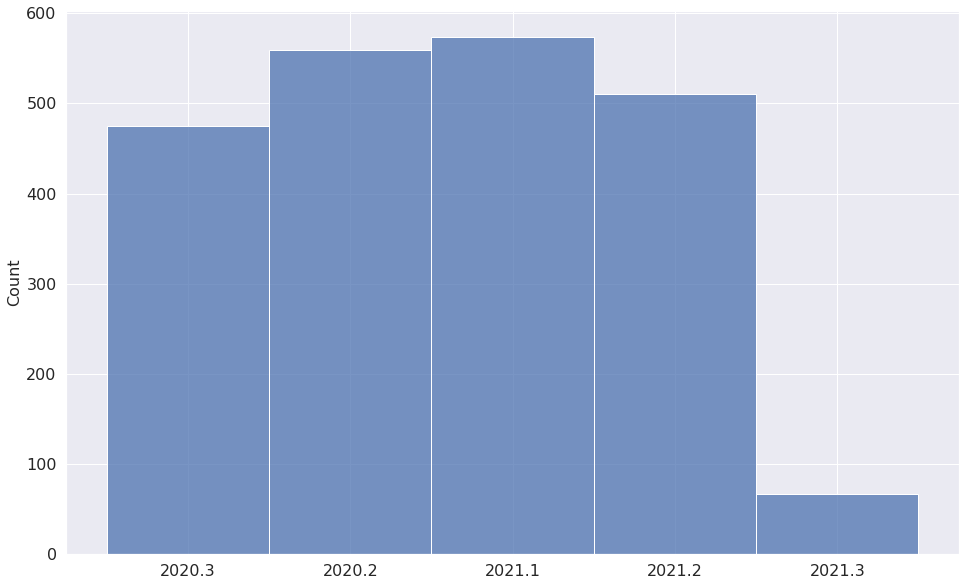

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
sns.histplot(data=df, x=list(itertools.chain(*df['Affected versions'])))
plt.show()

Посмотрим на содержимое 'summary' и 'description' для одной записи

In [9]:
df['summary'][0]

'Running subprocesses with Popen inside unittests can hang execution for too long'

In [10]:
print(df['description'][0])

I have the following unittest:

```
class MyTest(unittest.TestCase):
    def test(self):
        import subprocess
        import sys
        import time

        start = time.monotonic()

        try:
            subprocess.run([sys.executable, '-c', 'print("hello"); import time; time.sleep(10)'],
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=2)
        except subprocess.TimeoutExpired:
            pass

        try:
            subprocess.run([sys.executable, '-c', 'print("hello"); import time; time.sleep(10)'],
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=2)
        except subprocess.TimeoutExpired:
            pass

        end = time.monotonic()

        print(end - start)
```

When `timeout` equal `2` execution roughly takes 4 seconds as expected. But if you change `timeout` to `0.1`. execution will take ~10 seconds.



Поработаем с колонкой 'summary'

### Предобработка текста

In [11]:
import re

Удаляем пунктуацию и ненужные символы

In [12]:
df['cleaned_summary'] = df['summary'].map(lambda x: re.sub('[,\.!?\-\+\(\)\"\`\~:]', '', x))
df['cleaned_summary'] = df['cleaned_summary'].map(lambda x: re.sub('\s+', ' ', x))
df['cleaned_summary'] = df['cleaned_summary'].map(lambda x: x.lower())
df['cleaned_summary'] = df['cleaned_summary'].map(lambda x: x.replace("i'm", 'i am').replace("n't", ' not'))
df

,idReadable,created,summary,description,Affected versions,cleaned_summary
0,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3],running subprocesses with popen inside unittes...
1,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2],full project optimize imports alters library f...
2,PY-22369,1485334537463,DataFrame auto-update doesn't work with action...,Consider this example:\n\n```python\nimport pa...,[2021.1],dataframe autoupdate does not work with action...
3,PY-22469,1485863013851,PowerShell prompt doesn't show virtualenv,"Although the virtualenv seems activated, the p...",[2021.1],powershell prompt does not show virtualenv
4,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3],project requirements are not detected from set...
...,...,...,...,...,...,...
2180,PY-51608,1636987696450,Breakpoints not always hit in multi-threaded app,# Steps to Reproduce\n\nCreate a project using...,[2021.2],breakpoints not always hit in multithreaded app
2181,PY-51621,1637063283050,code insighte: Quick solution (+error) instead...,"Hi,\n**What I do:**\nI open huge JSON file (ab...",[2021.2],code insighte quick solution error instead of ...
2182,PY-51614,1637012454711,"IDE keeps disabling Python plugin, I get and e...",Here is the job log.\n\nI am unable to use the...,[2021.2],ide keeps disabling python plugin i get and er...
2183,PY-51605,1636977168955,"Better ""Invalid Python SDK"" handling",Quite often OS (usually macOS) or Python updat...,[2021.2],better invalid python sdk handling


Убираем стоп-слова и токенизируем

gensim.utils.simple_preprocess() - Convert a document into a list of tokens.


In [13]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
list_summary = df['cleaned_summary'].tolist()

In [15]:
final_out = []
for text in list_summary:
  preprocess_text = simple_preprocess(str(text), deacc=True)
  tmp = []
  for word in preprocess_text:
    if word not in stop_words:
      tmp.append(word)
  final_out.append(tmp)
# final_out

Преобразуем данные в такой формат, который можно было бы использовать в LDA

In [16]:
import gensim.corpora as corpora
from gensim.corpora import Dictionary  #This module implements the concept of a Dictionary – a mapping between words and their integer ids.
# doc2bow - Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.

In [17]:
dict_w_id = Dictionary(final_out)
d2bow = [dict_w_id.doc2bow(text) for text in final_out]

In [18]:
d2bow[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

### Модель: LDA

Количество топиков возьмем 50

In [19]:
from gensim.models import LdaMulticore

In [20]:
lda_model = LdaMulticore(corpus=d2bow,
                        id2word=dict_w_id,
                        num_topics=50, 
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True)

In [21]:
sorted(lda_model.print_topics(num_topics=10)) #10 самых важных тем

[(4,
  '0.096*"type" + 0.083*"breaks" + 0.078*"annotations" + 0.075*"refactoring" + 0.048*"class" + 0.042*"decorator" + 0.036*"stopped" + 0.036*"numpy" + 0.033*"super" + 0.033*"explicitly"'),
 (5,
  '0.135*"string" + 0.126*"line" + 0.064*"message" + 0.056*"different" + 0.040*"better" + 0.038*"macos" + 0.037*"display" + 0.037*"action" + 0.034*"properly" + 0.034*"characters"'),
 (12,
  '0.180*"function" + 0.110*"type" + 0.089*"without" + 0.042*"nested" + 0.040*"hint" + 0.037*"defined" + 0.037*"user" + 0.036*"hinting" + 0.022*"definition" + 0.021*"outside"'),
 (16,
  '0.291*"false" + 0.124*"positive" + 0.043*"highlighting" + 0.033*"level" + 0.031*"problems" + 0.030*"attributes" + 0.026*"instance" + 0.023*"open" + 0.022*"keeps" + 0.017*"showing"'),
 (24,
  '0.172*"debug" + 0.126*"add" + 0.068*"imported" + 0.054*"suggests" + 0.049*"compatibility" + 0.038*"hide" + 0.026*"stops" + 0.025*"js" + 0.023*"requirements" + 0.020*"unhandled"'),
 (25,
  '0.103*"inference" + 0.085*"type" + 0.084*"runni

Посчитаем Coherence Score для данной модели

In [22]:
from gensim.models import CoherenceModel

In [23]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_out, dictionary=dict_w_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6047778451252431


Визуализация

In [24]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [25]:
result = pyLDAvis.gensim_models.prepare(lda_model, d2bow, dict_w_id, mds="mmds")

In [26]:
result

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.399606  0.308841       1        1  4.170300
20    -0.145774 -0.466736       2        1  3.704239
44     0.017104 -0.478527       3        1  3.146711
23    -0.342745 -0.305413       4        1  2.775622
32     0.221129 -0.394831       5        1  2.745317
7      0.412028 -0.176853       6        1  2.711373
21    -0.390613 -0.183823       7        1  2.484883
27     0.286028 -0.308806       8        1  2.469365
16    -0.310647  0.314160       9        1  2.452547
38     0.428705  0.155016      10        1  2.358029
6     -0.232227 -0.361184      11        1  2.318087
13    -0.466657 -0.030817      12        1  2.283142
25    -0.404555  0.074279      13        1  2.271804
40     0.191316  0.413400      14        1  2.257786
14    -0.346214  0.008796      15        1  2.067862
10    -0.308229  0.209737      16        1  2.053053
9     -0.394537  0.172985      17        1  2.034938
5      0.254566  0.301006      18        1  2.031591
35    -0.348542 -0.095278      19        1  1.992847
12    -0.014814 -0.249065      20        1  1.960649
39    -0.074377 -0.352372      21        1  1.944507
28     0.079057 -0.385477      22        1  1.938115
1      0.339260 -0.238317      23        1  1.935653
46    -0.103315 -0.185798      24        1  1.892676
4     -0.009376  0.416086      25        1  1.867864
47     0.151026 -0.306888      26        1  1.848334
36    -0.193590  0.168106      27        1  1.795448
33     0.036355  0.336024      28        1  1.776115
42    -0.185232 -0.229355      29        1  1.749718
43    -0.084410  0.396827      30        1  1.738098
0     -0.150588  0.354269      31        1  1.736100
26     0.080432  0.081781      32        1  1.735552
24     0.416979 -0.058105      33        1  1.724897
17     0.318988 -0.083671      34        1  1.720986
18     0.313243  0.138777      35        1  1.698459
15     0.131062 -0.199273      36        1  1.672188
8      0.228577  0.176300      37        1  1.653783
48    -0.262406 -0.172354      38        1  1.648282
22     0.123613  0.352860      39        1  1.630598
41    -0.005298  0.174894      40        1  1.599896
29     0.382071  0.028993      41        1  1.580869
49     0.239179  0.038911      42        1  1.562334
3      0.121085  0.209894      43        1  1.502057
30     0.179146 -0.092335      44        1  1.480304
34     0.105711 -0.043916      45        1  1.476028
45    -0.198017  0.057017      46        1  1.464316
19    -0.092795  0.229448      47        1  1.454454
37    -0.226025  0.333857      48        1  1.451287
11    -0.036868 -0.015477      49        1  1.312729
31    -0.128414 -0.037592      50        1  1.118207, topic_info=             Term        Freq       Total Category  logprob  loglift
58         python  269.000000  269.000000  Default  30.0000  30.0000
35        pycharm  235.000000  235.000000  Default  29.0000  29.0000
65           code  127.000000  127.000000  Default  28.0000  28.0000
79           type  229.000000  229.000000  Default  27.0000  27.0000
190         error  107.000000  107.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
2330  substituted    0.773684    1.598626  Topic50  -5.3354   3.7677
2342     additive    0.773684    1.598626  Topic50  -5.3354   3.7677
2343      stacked    0.773684    1.598626  Topic50  -5.3354   3.7677
424     directive    0.554280    1.379222  Topic50  -5.6688   3.5818
2124       dotted    0.528609    1.353551  Topic50  -5.7163   3.5532

[1550 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1086     38  0.886460   ability
2383     17  0.930488      able
1378     38  0.780712  absolute
1633     10  0.769790  abstract
2260     20  0.829409  accepted
...     ...       ...       ...
2421     41  0.775258       xml
1899     42  0.826457      yaml
2765     45  0.